In [3]:
!pip install psutil

# LOAD LIBRARIES

In [4]:
import mlflow
import mlflow.xgboost
import xgboost as xgb

from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as plt
import pandas as pd
import os
import psutil

# SETTINGS

In [7]:
mlflow_arn = "arn:aws:sagemaker:eu-west-1:575618486322:mlflow-tracking-server/dev-mlflow"
mlflow_experiment_name = "02-sample-experiment"

# SET MLFLOW

In [8]:
mlflow.set_tracking_uri(mlflow_arn)
mlflow.set_experiment(mlflow_experiment_name)

<Experiment: artifact_location='s3://ipf-sds-datalake-dev-data-science-bucket/mlflow/2', creation_time=1730285259326, experiment_id='2', last_update_time=1730285259326, lifecycle_stage='active', name='02-sample-experiment', tags={}>

In [9]:
os.environ["MLFLOW_ENABLE_SYSTEM_METRICS_LOGGING"] = "true"
mlflow.enable_system_metrics_logging()

# LOAD DATA

In [10]:
# Load Diabetes dataset
data = load_diabetes()
X = data.data
y = data.target

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# BUILD A MODEL

In [8]:
# Create and train model
model = xgb.XGBRegressor(n_estimators=100, max_depth=3, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# BUILD ONE MORE MODEL WITH CUSTOM NAME

2024/10/30 11:23:10 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: `pynvml` is not installed, to log GPU metrics please run `pip install pynvml` to install it..
2024/10/30 11:23:10 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


Run ID: ae5e11fecce346719205071814cce379


/opt/conda/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [11:23:12] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1713397725960/work/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
2024/10/30 11:23:24 WARNING mlflow.models.model: Input example should be provided to infer model signature if the model signature is not provided when logging the model.
2024/10/30 11:23:24 INFO mlflow.tracking._tracking_service.client: 🏃 View run my-custom-name-new at: https://eu-west-1.experiments.sagemaker.aws/#/experiments/2/runs/ae5e11fecce346719205071814cce379.
2024/10/30 11:23:24 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://eu-west-1.experiments.sagemaker.aws/#/experiments/2.
2024/10/30 11:23:24 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monit

Logging completed.


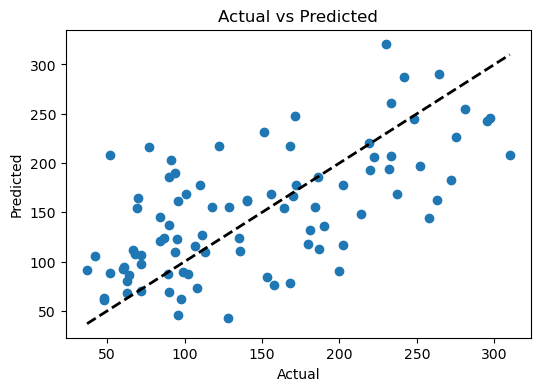

In [11]:
# Create and train model
model = xgb.XGBRegressor(n_estimators=100, max_depth=2, random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Create and log residuals plot as an artifact
plt.figure(figsize=(6,4))
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
residuals_plot_file = "residuals_plot.png"
plt.savefig(residuals_plot_file)

# Start a new MLflow run
with mlflow.start_run(run_name = "my-custom-name-new") as run:
    run_id = run.info.run_id
    print(f"Run ID: {run_id}")

    # Log parameters directly from the model
    params = model.get_params()
    for param, value in params.items():
        mlflow.log_param(param, value)

    mlflow.set_tag("model_type", "xgboost")

    # Log metrics
    mlflow.log_metric("mse", mse)
    mlflow.log_metric("r2", r2)

    # Log the model
    mlflow.xgboost.log_model(model, "model")

    # Log residuals plot as an artifact
    mlflow.log_artifact(residuals_plot_file)

    # Log a sample input
    sample_input = X_test[0]
    input_df = pd.DataFrame([sample_input], columns=data.feature_names)
    input_file = "sample_input.csv"
    input_df.to_csv(input_file, index=False)
    mlflow.log_artifact(input_file)

    # Remove temporary files
    os.remove(residuals_plot_file)
    os.remove(input_file)

print("Logging completed.")